In [1]:
import pandas as pd
import numpy as np
import torch

from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.utils import shuffle
import pandas as pd

import matplotlib.pyplot as plt

# 1. Loading data

In [2]:
train = pd.read_csv("train.csv").values
train = shuffle(train)
test  = pd.read_csv("test.csv").values

validation = train[0:4200]
train = train[4200:42000]

# 2. Converting data

In [3]:
X_data  = train[:, 1:].reshape(train.shape[0], 1, 28, 28)
X_data  = X_data.astype(float)
X_data /= 255.0
X_data  = torch.from_numpy(X_data);
X_label = train[:,0];
X_label = X_label.astype(int);
X_label = torch.from_numpy(X_label);
X_label = X_label.view(train.shape[0],-1);
print (X_data.size(), X_label.size())

torch.Size([37800, 1, 28, 28]) torch.Size([37800, 1])


In [4]:
Y_data  = validation[:, 1:].reshape(validation.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);
Y_label = validation[:,0];
Y_label = Y_label.astype(int);
Y_label = torch.from_numpy(Y_label);
Y_label = Y_label.view(validation.shape[0],-1);
print (Y_data.size(), Y_label.size())

torch.Size([4200, 1, 28, 28]) torch.Size([4200, 1])


8


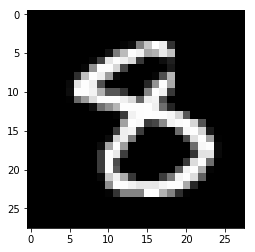

In [5]:
print(X_label[0].item())
plt.imshow(X_data[0][0,:,:],cmap='gray')

## Function for Validation

In [6]:
def evaluation(data, label, net):
    nb_data = data.shape[0]
    nb_batch = 10

    net.eval()

    loss = 0
    
    final_prediction = Variable(torch.zeros(nb_data, dtype=torch.int), requires_grad = False)
    if use_gpu:
        final_prediction = final_prediction.cuda()
    for each_sample in range(0, nb_data, nb_batch):
        sample_data = Variable(data[each_sample:each_sample+nb_batch].clone())
        sample_data = sample_data.type(torch.FloatTensor)
        
        sample_label = Variable(label[each_sample:each_sample+nb_batch].clone(), requires_grad = False)
        sample_label = sample_label.type(torch.LongTensor)
        if use_gpu:
            sample_data = sample_data.cuda()
            sample_label = sample_label.cuda()
        optimizer.zero_grad()
        sample_out   = net(sample_data)
        sample_label = sample_label.view(nb_batch)
        sample_loss  = criterion(sample_out, sample_label)      
        loss = loss+sample_loss
        
        _, pred = torch.max(sample_out, 1)
        final_prediction[each_sample:each_sample+nb_batch] = pred
    correct = 0
    if use_gpu:
        label = Variable(label).cuda()
    for i in range(nb_data):
        if final_prediction[i] == label[i]:
            correct += 1
            
    loss = loss/(nb_data/nb_batch)
    accuracy = correct/nb_data*100
    
    return loss, accuracy

# 3-1. Train for LeNet5

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
net = LeNet5()
print (net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net = net.cuda()
    print ('USE GPU')
else:
    print ('USE CPU')
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

USE GPU


In [10]:
nb_train = train.shape[0]
nb_epoch = 50
nb_index = 0
nb_batch = 10

for epoch in range(nb_epoch):
    net.eval()
    train_loss = 0
    for nb_index in range(0, nb_train, nb_batch):
        mini_data  = Variable(X_data[nb_index:(nb_index+nb_batch)].clone())
        mini_label = Variable(X_label[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
        mini_data  = mini_data.type(torch.FloatTensor)
        mini_label = mini_label.type(torch.LongTensor)
        if use_gpu:
            mini_data  = mini_data.cuda()
            mini_label = mini_label.cuda()
        optimizer.zero_grad()
        mini_out   = net(mini_data)
        mini_label = mini_label.view(nb_batch)
        mini_loss  = criterion(mini_out, mini_label)
        mini_loss.backward()
        optimizer.step()
        train_loss += mini_loss
    train_loss = train_loss/(nb_train/nb_batch)
    if (epoch + 1) % 1 == 0:
        val_loss, val_acc = evaluation(Y_data, Y_label, net)
        print("Epoch = %d, Train = %f, Val = %f(%f%%)" %(epoch+1, train_loss.data.item(), val_loss.data.item(), val_acc))

Epoch = 1, Train = 2.280325, Val = 2.233967(38.666667%)
Epoch = 2, Train = 1.528717, Val = 0.636360(80.690476%)
Epoch = 3, Train = 0.474743, Val = 0.383500(88.380952%)
Epoch = 4, Train = 0.339689, Val = 0.297159(91.380952%)
Epoch = 5, Train = 0.276905, Val = 0.246397(93.190476%)
Epoch = 6, Train = 0.233288, Val = 0.208009(94.166667%)
Epoch = 7, Train = 0.200484, Val = 0.180420(94.880952%)
Epoch = 8, Train = 0.175219, Val = 0.159438(95.357143%)
Epoch = 9, Train = 0.155352, Val = 0.142863(95.904762%)
Epoch = 10, Train = 0.139546, Val = 0.129927(96.261905%)
Epoch = 11, Train = 0.127192, Val = 0.120201(96.452381%)
Epoch = 12, Train = 0.117183, Val = 0.112537(96.761905%)
Epoch = 13, Train = 0.108896, Val = 0.106315(96.857143%)
Epoch = 14, Train = 0.101966, Val = 0.101436(97.023810%)
Epoch = 15, Train = 0.095998, Val = 0.097267(97.000000%)
Epoch = 16, Train = 0.090854, Val = 0.093632(97.071429%)
Epoch = 17, Train = 0.086337, Val = 0.090415(97.285714%)
Epoch = 18, Train = 0.082359, Val = 0.08

# 4-1. Testing phase

In [11]:
Y_data  = test.reshape(test.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);
print (Y_data.size())
nb_test = test.shape[0]

net.eval()

final_prediction = np.ndarray(shape = (nb_test, 2), dtype=int)
for each_sample in range(nb_test):
    sample_data = Variable(Y_data[each_sample:each_sample+1].clone())
    sample_data = sample_data.type(torch.FloatTensor)
    if use_gpu:
        sample_data = sample_data.cuda()
    sample_out = net(sample_data)
    _, pred = torch.max(sample_out, 1)
    final_prediction[each_sample][0] = 1 + each_sample
    final_prediction[each_sample][1] = pred.data
    if (each_sample + 1) % 2000 == 0:
        print("Total tested = %d" %(each_sample + 1))

torch.Size([28000, 1, 28, 28])
Total tested = 2000
Total tested = 4000
Total tested = 6000
Total tested = 8000
Total tested = 10000
Total tested = 12000
Total tested = 14000
Total tested = 16000
Total tested = 18000
Total tested = 20000
Total tested = 22000
Total tested = 24000
Total tested = 26000
Total tested = 28000


In [12]:
submission = pd.DataFrame(final_prediction, dtype=int, columns=['ImageId', 'Label'])
submission.to_csv('pytorch_LeNet5.csv', index=False, header=True)

# 3-2. Train for LeNet7

In [15]:
class LeNet7(nn.Module):
    def __init__(self):
        super(LeNet7, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.conv3 = nn.Conv2d(16, 26, (5,5))
        self.fc0   = nn.Linear(26, 16*5*5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [16]:
net = LeNet7()
print (net)

LeNet7(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(5, 5), stride=(1, 1))
  (fc0): Linear(in_features=26, out_features=400, bias=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net = net.cuda()
    print ('USE GPU')
else:
    print ('USE CPU')
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

USE GPU


In [19]:
Y_data  = validation[:, 1:].reshape(validation.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);
Y_label = validation[:,0];
Y_label = Y_label.astype(int);
Y_label = torch.from_numpy(Y_label);
Y_label = Y_label.view(validation.shape[0],-1);
print (Y_data.size(), Y_label.size())

torch.Size([4200, 1, 28, 28]) torch.Size([4200, 1])


In [20]:
nb_train = train.shape[0]
nb_epoch = 50
nb_index = 0
nb_batch = 10

for epoch in range(nb_epoch):
    net.eval()
    train_loss = 0
    for nb_index in range(0, nb_train, nb_batch):
        mini_data  = Variable(X_data[nb_index:(nb_index+nb_batch)].clone())
        mini_label = Variable(X_label[nb_index:(nb_index+nb_batch)].clone(), requires_grad = False)
        mini_data  = mini_data.type(torch.FloatTensor)
        mini_label = mini_label.type(torch.LongTensor)
        if use_gpu:
            mini_data  = mini_data.cuda()
            mini_label = mini_label.cuda()
        optimizer.zero_grad()
        mini_out   = net(mini_data)
        mini_label = mini_label.view(nb_batch)
        mini_loss  = criterion(mini_out, mini_label)
        mini_loss.backward()
        optimizer.step()
        train_loss += mini_loss
    train_loss = train_loss/(nb_train/nb_batch)
    if (epoch + 1) % 1 == 0:
        val_loss, val_acc = evaluation(Y_data, Y_label, net)
        print("Epoch = %d, Train = %f, Val = %f(%f%%)" %(epoch+1, train_loss.data.item(), val_loss.data.item(), val_acc))

Epoch = 1, Train = 2.301973, Val = 2.300755(10.880952%)
Epoch = 2, Train = 2.301140, Val = 2.299932(11.738095%)
Epoch = 3, Train = 2.300627, Val = 2.299316(11.738095%)
Epoch = 4, Train = 2.300126, Val = 2.298666(11.738095%)
Epoch = 5, Train = 2.299430, Val = 2.297744(11.738095%)
Epoch = 6, Train = 2.298233, Val = 2.296066(11.738095%)
Epoch = 7, Train = 2.295747, Val = 2.292399(11.738095%)
Epoch = 8, Train = 2.289316, Val = 2.281463(11.738095%)
Epoch = 9, Train = 2.262844, Val = 2.219127(42.285714%)
Epoch = 10, Train = 1.726378, Val = 1.057977(63.119048%)
Epoch = 11, Train = 0.736975, Val = 0.537991(82.904762%)
Epoch = 12, Train = 0.454492, Val = 0.386562(88.357143%)
Epoch = 13, Train = 0.348104, Val = 0.295523(91.071429%)
Epoch = 14, Train = 0.274956, Val = 0.236894(92.857143%)
Epoch = 15, Train = 0.223962, Val = 0.196807(94.119048%)
Epoch = 16, Train = 0.188671, Val = 0.168120(95.000000%)
Epoch = 17, Train = 0.163899, Val = 0.148708(95.476190%)
Epoch = 18, Train = 0.146044, Val = 0.13

# 4-2. Testing phase

In [21]:
Y_data  = test.reshape(test.shape[0], 1, 28, 28)
Y_data  = Y_data.astype(float)
Y_data /= 255.0
Y_data  = torch.from_numpy(Y_data);
print (Y_data.size())
nb_test = test.shape[0]

net.eval()

final_prediction = np.ndarray(shape = (nb_test, 2), dtype=int)
for each_sample in range(nb_test):
    sample_data = Variable(Y_data[each_sample:each_sample+1].clone())
    sample_data = sample_data.type(torch.FloatTensor)
    if use_gpu:
        sample_data = sample_data.cuda()
    sample_out = net(sample_data)
    _, pred = torch.max(sample_out, 1)
    final_prediction[each_sample][0] = 1 + each_sample
    final_prediction[each_sample][1] = pred.data
    if (each_sample + 1) % 2000 == 0:
        print("Total tested = %d" %(each_sample + 1))

torch.Size([28000, 1, 28, 28])
Total tested = 2000
Total tested = 4000
Total tested = 6000
Total tested = 8000
Total tested = 10000
Total tested = 12000
Total tested = 14000
Total tested = 16000
Total tested = 18000
Total tested = 20000
Total tested = 22000
Total tested = 24000
Total tested = 26000
Total tested = 28000


In [22]:
submission = pd.DataFrame(final_prediction, dtype=int, columns=['ImageId', 'Label'])
submission.to_csv('pytorch_LeNet7.csv', index=False, header=True)